### Import Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### Load Raw Data

In [13]:
employee_survey_data = pd.read_csv('../data/employee_survey_data.csv')

general_data = pd.read_csv('../data/general_data.csv')

manager_survey_data = pd.read_csv('../data/manager_survey_data.csv')

in_time = pd.read_csv('../data/in_time.csv').rename(columns={'Unnamed: 0': 'EmployeeID'}).set_index('EmployeeID')

out_time = pd.read_csv('../data/out_time.csv').rename(columns={'Unnamed: 0': 'EmployeeID'}).set_index('EmployeeID')


### Merge data into final dataset

In [14]:
in_time = in_time.apply(pd.to_datetime)

out_time = out_time.apply(pd.to_datetime)

actual_working_hours = out_time - in_time

working_hours_float = actual_working_hours.apply(lambda x: x.dt.total_seconds() / 3600)

mean_hours = working_hours_float.mean(axis=1)

overtime_days = (working_hours_float > 8).sum(axis=1)

absent_days = in_time.isnull().sum(axis=1)

time_features = pd.DataFrame({
    'EmployeeID': mean_hours.index,
    'Mean_Work_Hours': mean_hours.values,
    'Overtime_Days_Count': overtime_days.values,
    'Absent_Days_Count': absent_days.values
})

In [15]:
df_final = general_data.merge(employee_survey_data,on='EmployeeID', how='left')
df_final = df_final.merge(manager_survey_data, on = 'EmployeeID', how='left')
df_final = df_final.merge(time_features, on ='EmployeeID', how='left')

In [5]:
df_final.head(3)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Mean_Work_Hours,Overtime_Days_Count,Absent_Days_Count
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,0,0,3.0,4.0,2.0,3,3,7.373651,0,29
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,1,4,3.0,2.0,4.0,2,4,7.718969,42,25
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,0,3,2.0,2.0,1.0,3,3,7.013240,0,19


### EDA

##### Data Understanding

In [6]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

##### Missing values

In [16]:
# Check for missing values
missing_values = df_final.isnull().sum()
missing_percentage = (missing_values / len(df_final)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_values,
    'Percentage': missing_percentage
}).sort_values(by='Missing_Count', ascending=False)

print(missing_df[missing_df['Missing_Count'] > 0])

                         Missing_Count  Percentage
WorkLifeBalance                     38    0.861678
EnvironmentSatisfaction             25    0.566893
JobSatisfaction                     20    0.453515
NumCompaniesWorked                  19    0.430839
TotalWorkingYears                    9    0.204082


##### Dataset shape and summary

In [17]:
print(f"Dataset Shape: {df_final.shape}")
print(f"\nNumber of Features: {df_final.shape[1]}")
print(f"Number of Records: {df_final.shape[0]}")
print(f"\nDuplicate rows: {df_final.duplicated().sum()}")

Dataset Shape: (4410, 32)

Number of Features: 32
Number of Records: 4410

Duplicate rows: 0


##### Target variable distribution

Attrition Distribution:
Attrition
No     3699
Yes     711
Name: count, dtype: int64

Attrition Rate: Attrition
No     83.88
Yes    16.12
Name: proportion, dtype: float64


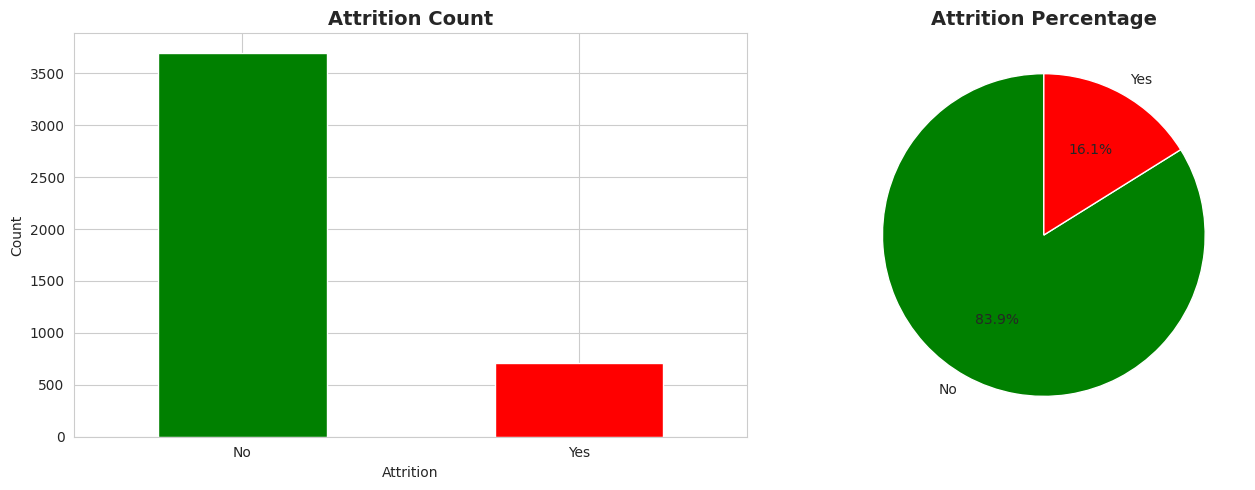

In [18]:
if 'Attrition' in df_final.columns:
    print("Attrition Distribution:")
    print(df_final['Attrition'].value_counts())
    print(f"\nAttrition Rate: {(df_final['Attrition'].value_counts(normalize=True) * 100).round(2)}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Count plot
    df_final['Attrition'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
    axes[0].set_title('Attrition Count', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Attrition')
    axes[0].set_ylabel('Count')
    axes[0].tick_params(rotation=0)
    
    # Pie chart
    df_final['Attrition'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                               colors=['green', 'red'], startangle=90)
    axes[1].set_title('Attrition Percentage', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()
else:
    print("Attrition column not found in dataset")

### 2. Univariate Analysis

#### Numerical Features

In [19]:
# Identify numerical columns
numerical_cols = df_final.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Numerical Features ({len(numerical_cols)}): ")
print(numerical_cols)

# Summary statistics
df_final[numerical_cols].describe().T

Numerical Features (24): 
['Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'Mean_Work_Hours', 'Overtime_Days_Count', 'Absent_Days_Count']


,count,mean,std,min,25%,50%,75%,max
Age,4410.0,36.923810,9.133301,18.000000,30.000000,36.000000,43.000000,60.00000
DistanceFromHome,4410.0,9.192517,8.105026,1.000000,2.000000,7.000000,14.000000,29.00000
Education,4410.0,2.912925,1.023933,1.000000,2.000000,3.000000,4.000000,5.00000
EmployeeCount,4410.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000
EmployeeID,4410.0,2205.500000,1273.201673,1.000000,1103.250000,2205.500000,3307.750000,4410.00000
JobLevel,4410.0,2.063946,1.106689,1.000000,1.000000,2.000000,3.000000,5.00000
MonthlyIncome,4410.0,65029.312925,47068.888559,10090.000000,29110.000000,49190.000000,83800.000000,199990.00000
NumCompaniesWorked,4391.0,2.694830,2.498887,0.000000,1.000000,2.000000,4.000000,9.00000
PercentSalaryHike,4410.0,15.209524,3.659108,11.000000,12.000000,14.000000,18.000000,25.00000
StandardHours,4410.0,8.000000,0.000000,8.000000,8.000000,8.000000,8.000000,8.00000


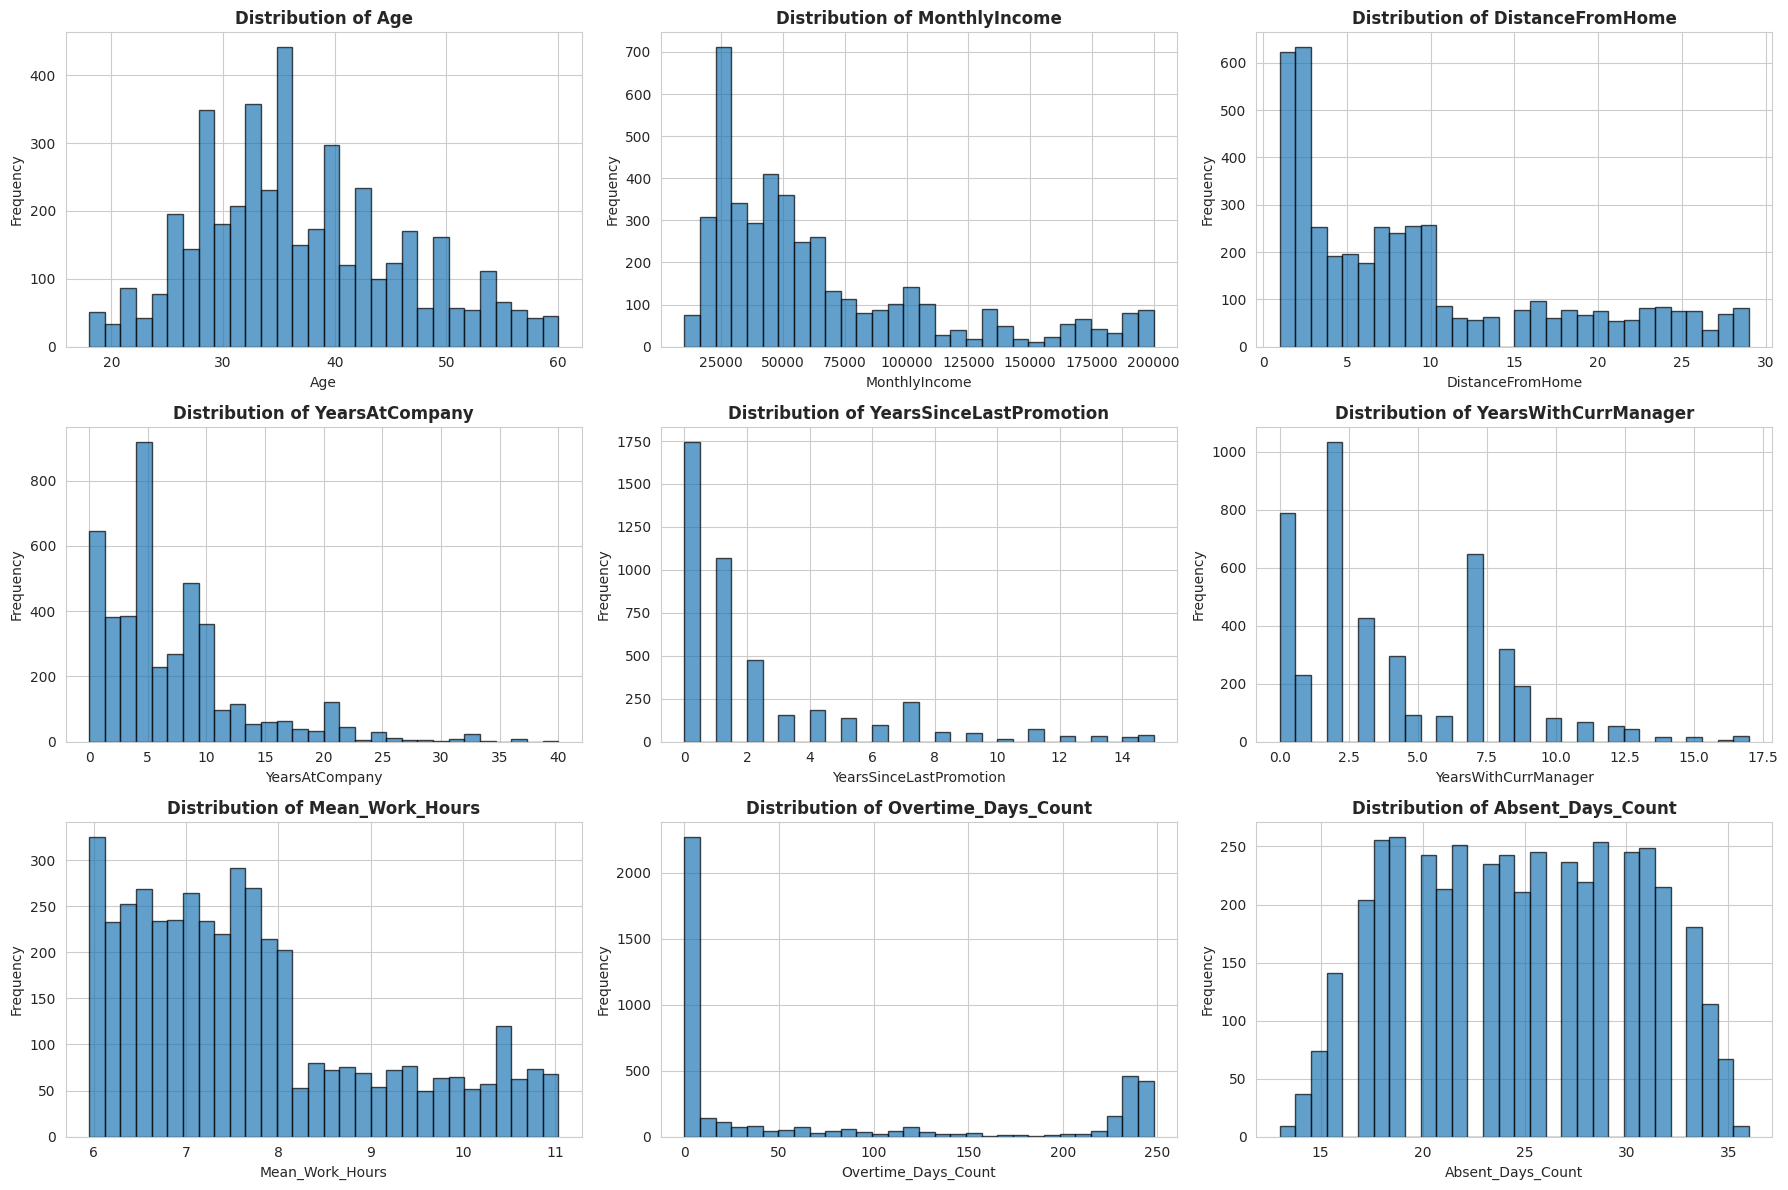

In [20]:
# Distribution plots for key numerical features
key_numerical = ['Age', 'MonthlyIncome', 'DistanceFromHome', 'YearsAtCompany', 
                 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
                 'Mean_Work_Hours', 'Overtime_Days_Count', 'Absent_Days_Count']

# Filter only existing columns
key_numerical = [col for col in key_numerical if col in df_final.columns]

if len(key_numerical) > 0:
    n_cols = 3
    n_rows = (len(key_numerical) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(key_numerical):
        df_final[col].hist(bins=30, ax=axes[idx], edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
    
    # Hide empty subplots
    for idx in range(len(key_numerical), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No key numerical features found")

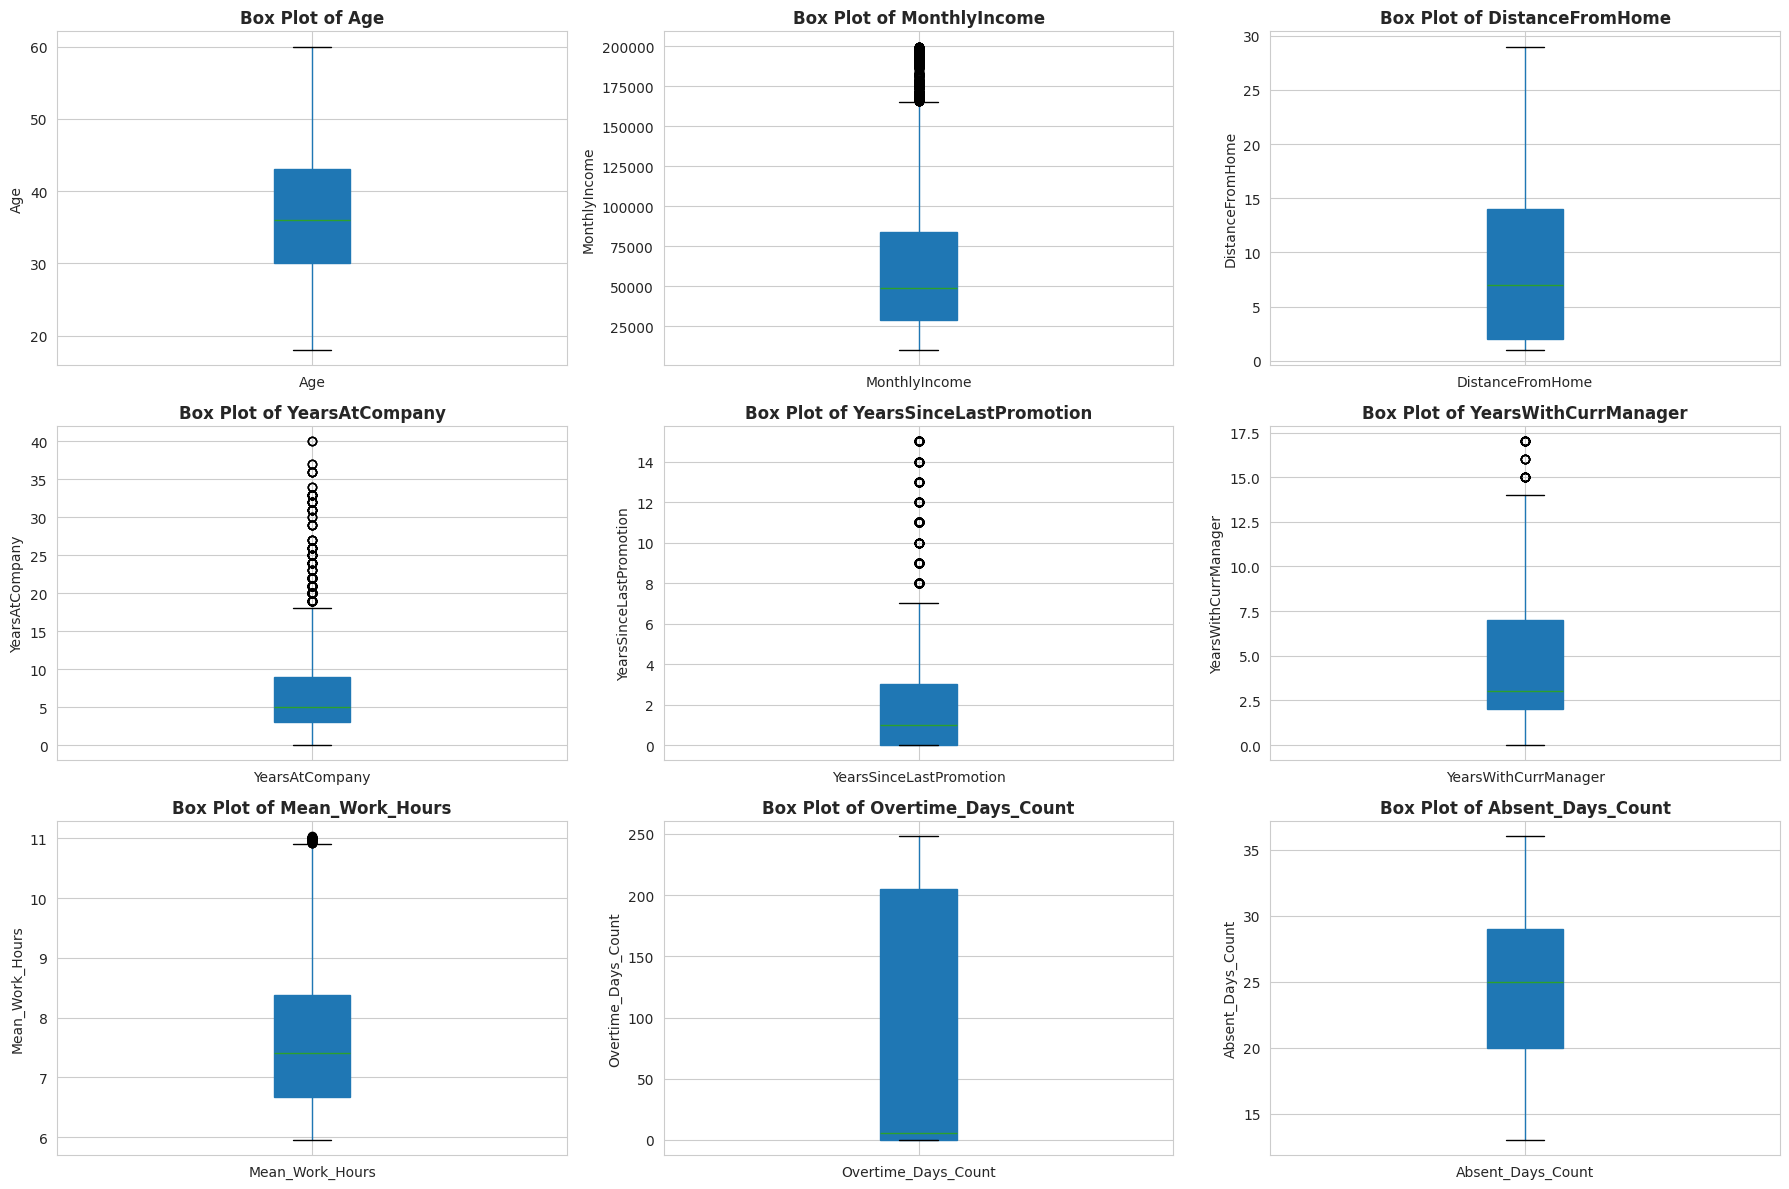

In [21]:
# Box plots to detect outliers
if len(key_numerical) > 0:
    n_cols = 3
    n_rows = (len(key_numerical) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(key_numerical):
        df_final.boxplot(column=col, ax=axes[idx], patch_artist=True)
        axes[idx].set_title(f'Box Plot of {col}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel(col)
    
    # Hide empty subplots
    for idx in range(len(key_numerical), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

#### Categorical Features

In [22]:
# Identify categorical columns
categorical_cols = df_final.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical Features ({len(categorical_cols)}): ")
print(categorical_cols)

# Show unique values for each categorical feature
for col in categorical_cols:
    print(f"\n{col}: {df_final[col].nunique()} unique values")
    print(df_final[col].value_counts())

Categorical Features (8): 
['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18']

Attrition: 2 unique values
Attrition
No     3699
Yes     711
Name: count, dtype: int64

BusinessTravel: 3 unique values
BusinessTravel
Travel_Rarely        3129
Travel_Frequently     831
Non-Travel            450
Name: count, dtype: int64

Department: 3 unique values
Department
Research & Development    2883
Sales                     1338
Human Resources            189
Name: count, dtype: int64

EducationField: 6 unique values
EducationField
Life Sciences       1818
Medical             1392
Marketing            477
Technical Degree     396
Other                246
Human Resources       81
Name: count, dtype: int64

Gender: 2 unique values
Gender
Male      2646
Female    1764
Name: count, dtype: int64

JobRole: 9 unique values
JobRole
Sales Executive              978
Research Scientist           876
Laboratory Technician        777
Manufacturing Dir

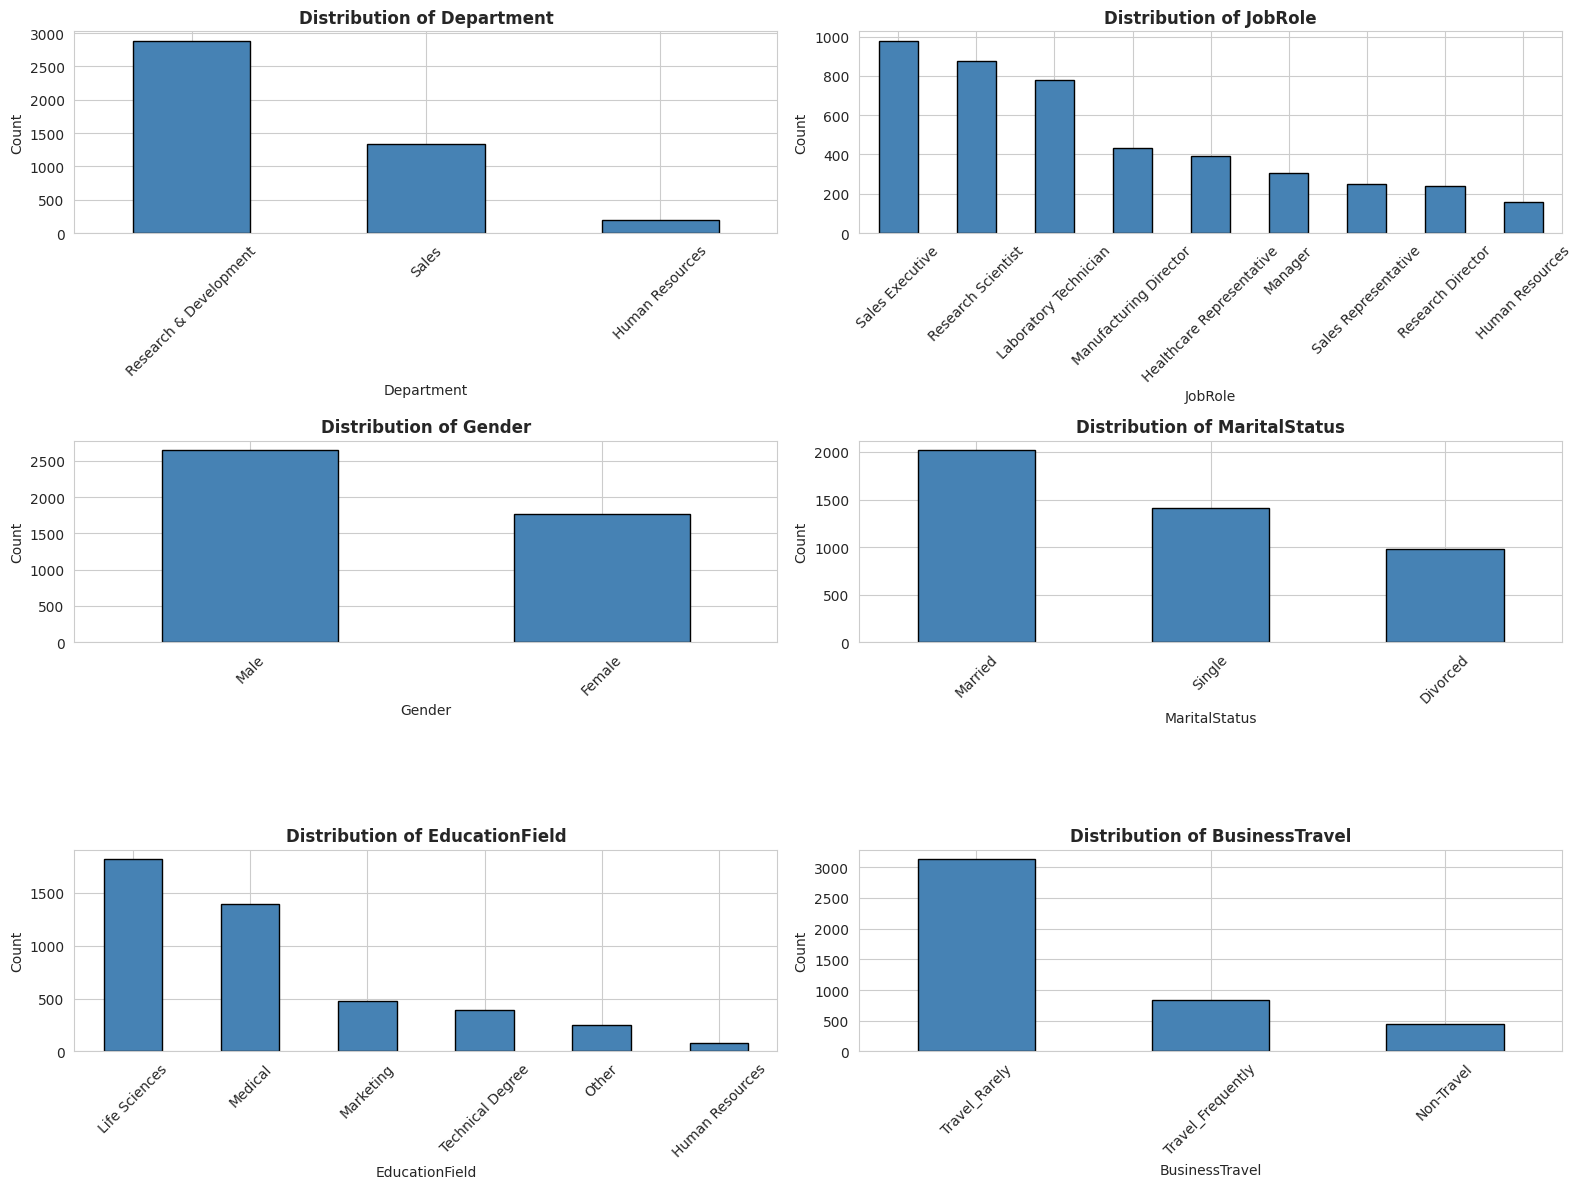

In [23]:
# Visualize categorical features
key_categorical = ['Department', 'JobRole', 'Gender', 'MaritalStatus', 
                   'EducationField', 'BusinessTravel', 'OverTime']

# Filter only existing columns
key_categorical = [col for col in key_categorical if col in df_final.columns]

if len(key_categorical) > 0:
    n_cols = 2
    n_rows = (len(key_categorical) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(key_categorical):
        df_final[col].value_counts().plot(kind='bar', ax=axes[idx], color='steelblue', edgecolor='black')
        axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
        axes[idx].tick_params(axis='x', rotation=45)
    
    # Hide empty subplots
    for idx in range(len(key_categorical), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No key categorical features found")

### 3. Bivariate Analysis

#### Attrition vs Categorical Features

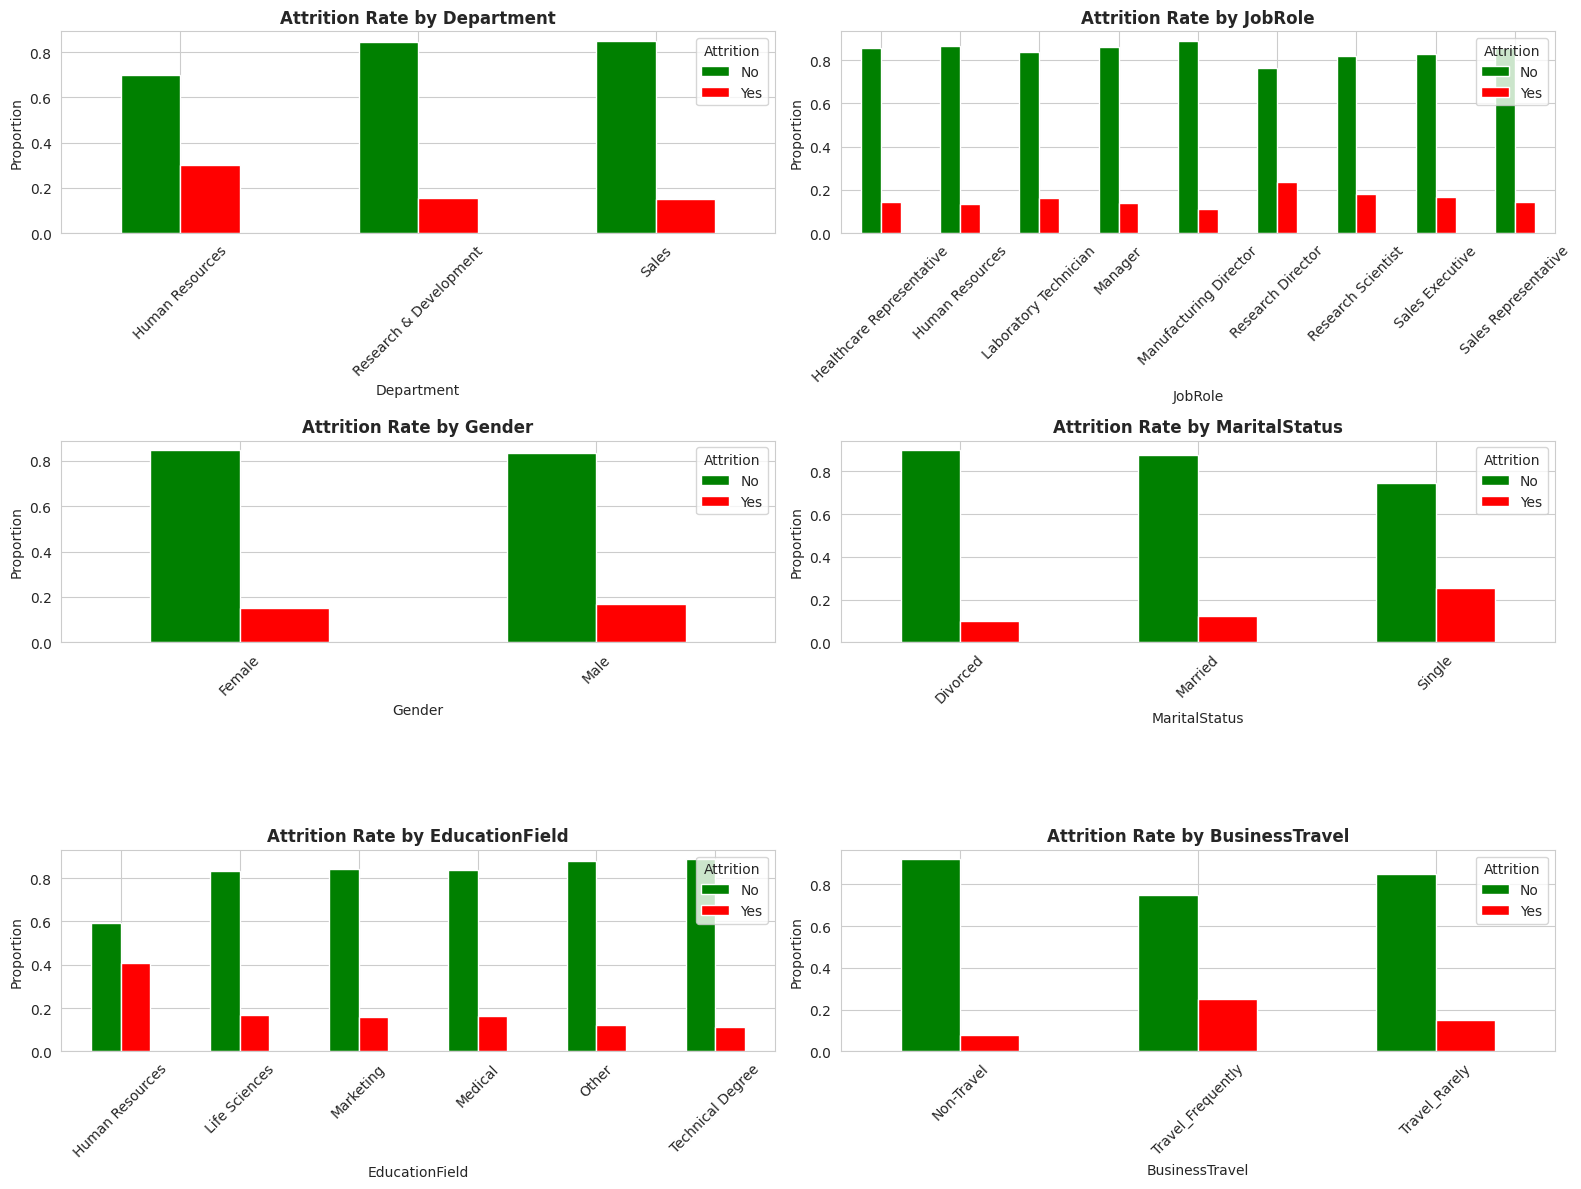

In [24]:
# Attrition rate by categorical features
if 'Attrition' in df_final.columns and len(key_categorical) > 0:
    n_cols = 2
    n_rows = (len(key_categorical) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(key_categorical):
        attrition_rate = df_final.groupby(col)['Attrition'].value_counts(normalize=True).unstack()
        attrition_rate.plot(kind='bar', ax=axes[idx], stacked=False, color=['green', 'red'])
        axes[idx].set_title(f'Attrition Rate by {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Proportion')
        axes[idx].legend(title='Attrition')
        axes[idx].tick_params(axis='x', rotation=45)
    
    # Hide empty subplots
    for idx in range(len(key_categorical), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Cannot analyze - Attrition column not found or no categorical features")

#### Attrition vs Numerical Features

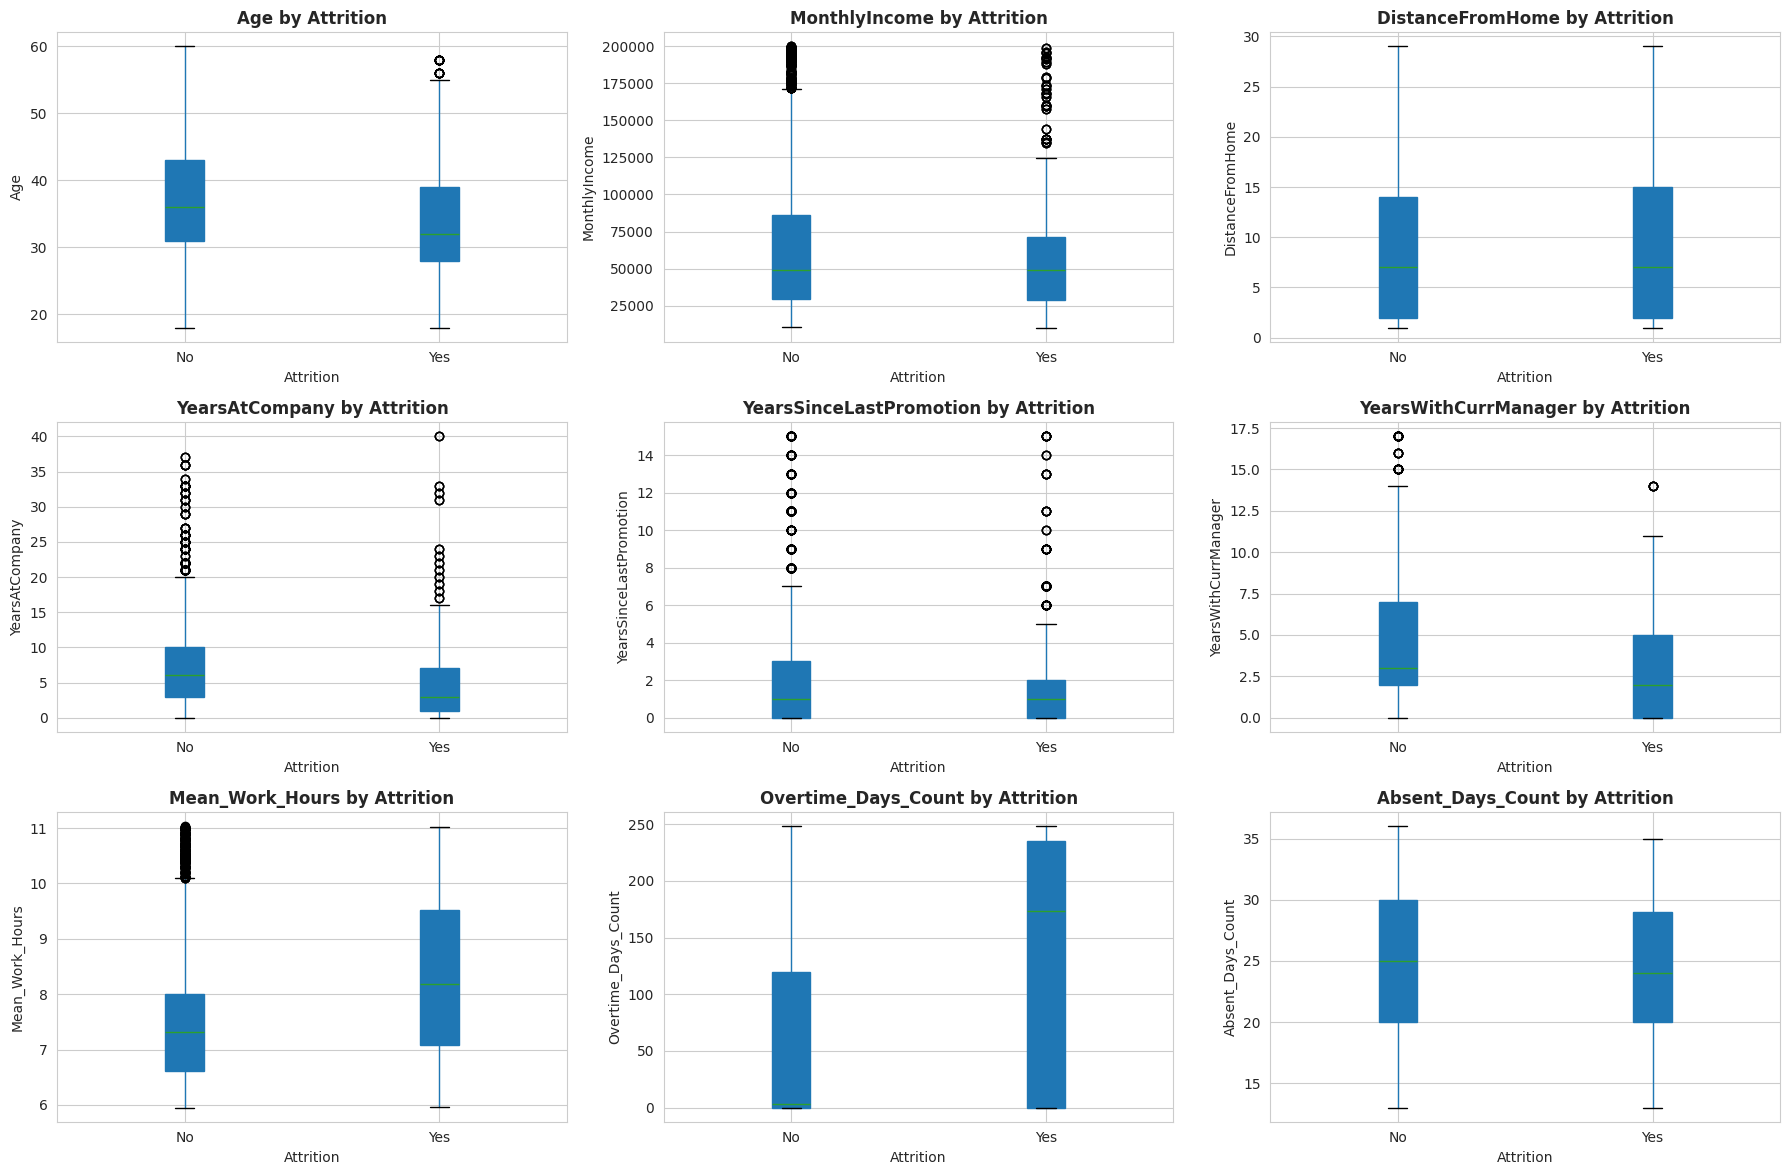

In [25]:
# Box plots for numerical features by attrition
if 'Attrition' in df_final.columns and len(key_numerical) > 0:
    n_cols = 3
    n_rows = (len(key_numerical) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(key_numerical):
        df_final.boxplot(column=col, by='Attrition', ax=axes[idx], patch_artist=True)
        axes[idx].set_title(f'{col} by Attrition', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Attrition')
        axes[idx].set_ylabel(col)
        plt.sca(axes[idx])
        plt.xticks(rotation=0)
    
    # Hide empty subplots
    for idx in range(len(key_numerical), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('')  # Remove default title
    plt.tight_layout()
    plt.show()
else:
    print("Cannot analyze - Attrition column not found or no numerical features")

### 4. Correlation Analysis

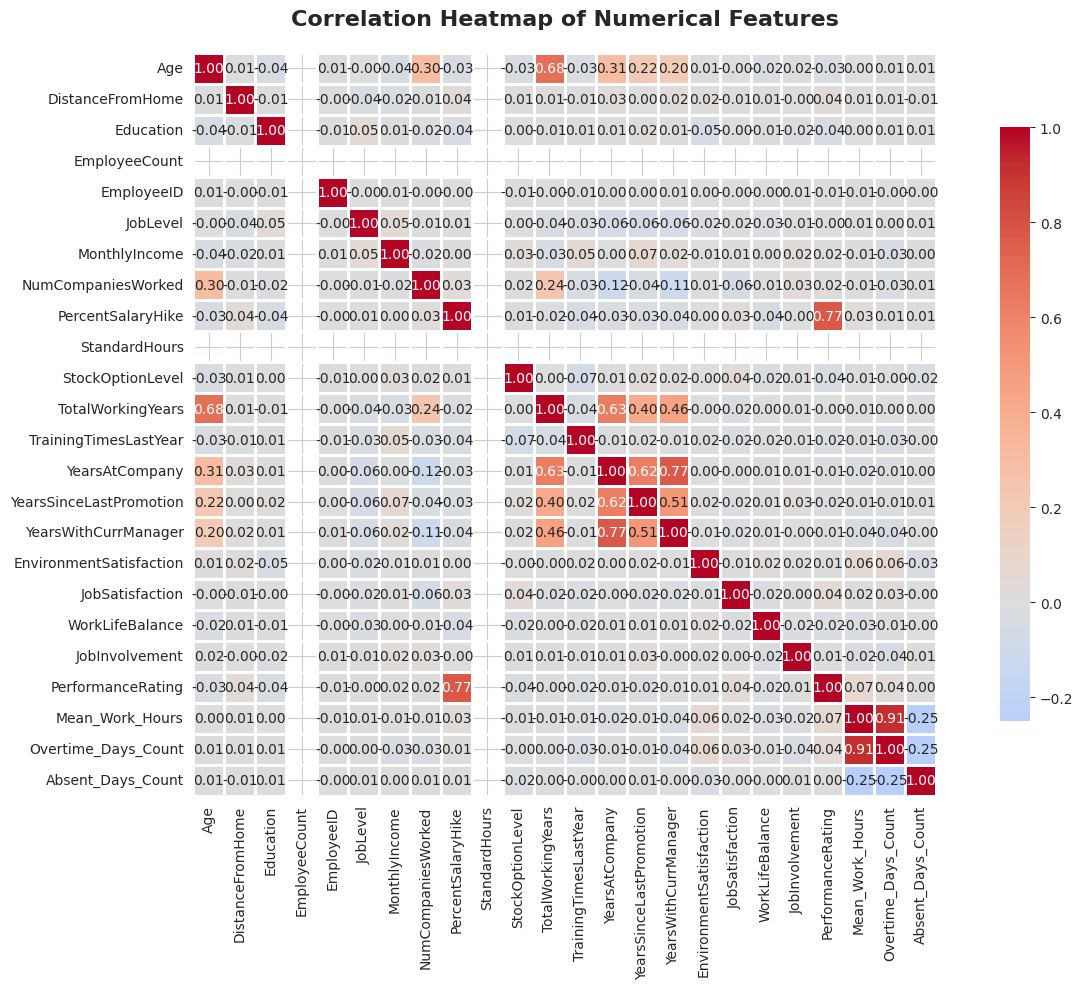


Highly Correlated Features (|correlation| > 0.7):
        Feature 1            Feature 2  Correlation
PercentSalaryHike    PerformanceRating     0.773550
   YearsAtCompany YearsWithCurrManager     0.769212
  Mean_Work_Hours  Overtime_Days_Count     0.914363


In [26]:
# Correlation matrix for numerical features
if len(numerical_cols) > 0:
    plt.figure(figsize=(14, 10))
    correlation_matrix = df_final[numerical_cols].corr()
    
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Heatmap of Numerical Features', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Show highly correlated features (absolute correlation > 0.7)
    print("\nHighly Correlated Features (|correlation| > 0.7):")
    high_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.7:
                high_corr.append({
                    'Feature 1': correlation_matrix.columns[i],
                    'Feature 2': correlation_matrix.columns[j],
                    'Correlation': correlation_matrix.iloc[i, j]
                })
    
    if high_corr:
        high_corr_df = pd.DataFrame(high_corr)
        print(high_corr_df.to_string(index=False))
    else:
        print("No highly correlated feature pairs found")
else:
    print("No numerical features available for correlation analysis")

Correlation with Attrition:
Overtime_Days_Count        0.233609
Mean_Work_Hours            0.201688
NumCompaniesWorked         0.042345
PercentSalaryHike          0.032533
PerformanceRating          0.023403
EmployeeID                -0.004729
StockOptionLevel          -0.006839
DistanceFromHome          -0.009730
JobLevel                  -0.010290
Education                 -0.015111
JobInvolvement            -0.015588
MonthlyIncome             -0.031176
YearsSinceLastPromotion   -0.033019
Absent_Days_Count         -0.043517
TrainingTimesLastYear     -0.049431
WorkLifeBalance           -0.062756
EnvironmentSatisfaction   -0.102142
JobSatisfaction           -0.102847
YearsAtCompany            -0.134392
YearsWithCurrManager      -0.156199
Age                       -0.159205
TotalWorkingYears         -0.170338
EmployeeCount                   NaN
StandardHours                   NaN
Name: Attrition_encoded, dtype: float64


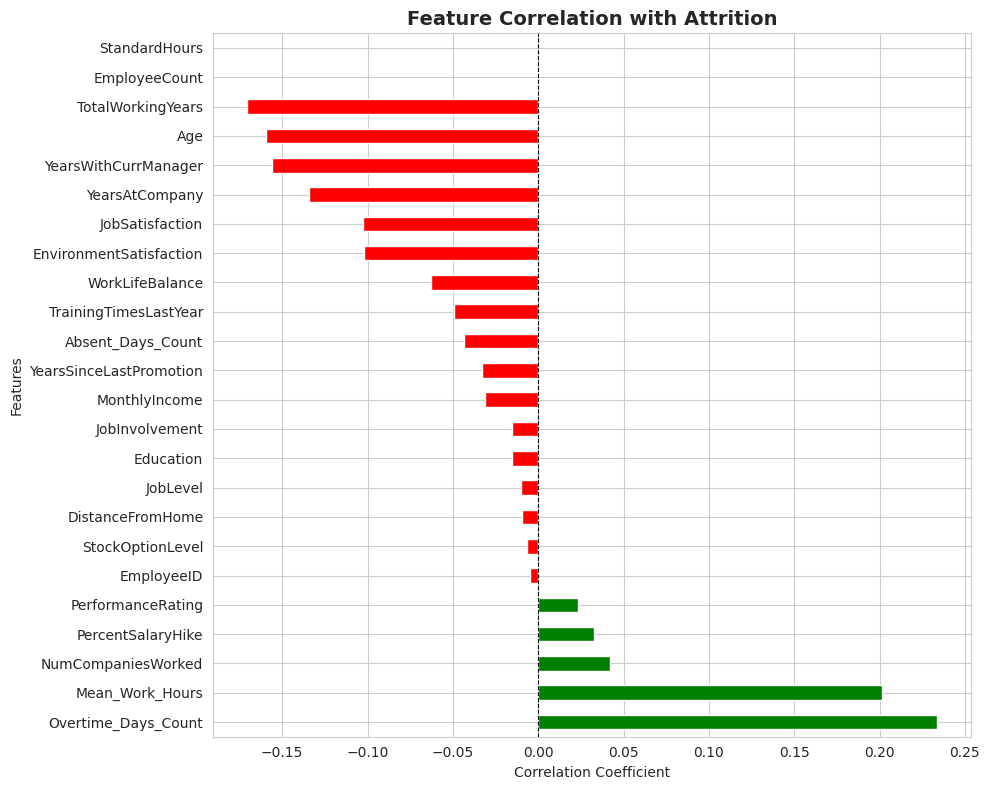

In [27]:
# Correlation with target variable (if Attrition is numeric or can be converted)
if 'Attrition' in df_final.columns:
    # Create a copy and encode Attrition if it's categorical
    df_temp = df_final.copy()
    if df_temp['Attrition'].dtype == 'object':
        df_temp['Attrition_encoded'] = df_temp['Attrition'].map({'Yes': 1, 'No': 0})
        target_col = 'Attrition_encoded'
    else:
        target_col = 'Attrition'
    
    # Calculate correlation with target
    target_corr = df_temp[numerical_cols + [target_col]].corr()[target_col].drop(target_col).sort_values(ascending=False)
    
    print("Correlation with Attrition:")
    print(target_corr)
    
    # Visualize top correlations
    plt.figure(figsize=(10, 8))
    target_corr.plot(kind='barh', color=['green' if x > 0 else 'red' for x in target_corr])
    plt.title('Feature Correlation with Attrition', fontsize=14, fontweight='bold')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Features')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.show()
else:
    print("Attrition column not found")

### 5. Key Insights Summary

In [28]:
print("=" * 80)
print("EDA KEY INSIGHTS")
print("=" * 80)

print(f"\n1. DATASET OVERVIEW:")
print(f"   - Total Records: {df_final.shape[0]}")
print(f"   - Total Features: {df_final.shape[1]}")
print(f"   - Numerical Features: {len(numerical_cols)}")
print(f"   - Categorical Features: {len(categorical_cols)}")

if 'Attrition' in df_final.columns:
    attrition_rate = (df_final['Attrition'].value_counts(normalize=True).get('Yes', 0) * 100)
    print(f"\n2. TARGET VARIABLE:")
    print(f"   - Attrition Rate: {attrition_rate:.2f}%")
    print(f"   - Class Distribution: {dict(df_final['Attrition'].value_counts())}")

missing_total = df_final.isnull().sum().sum()
print(f"\n3. DATA QUALITY:")
print(f"   - Total Missing Values: {missing_total}")
print(f"   - Duplicate Records: {df_final.duplicated().sum()}")

if missing_total > 0:
    print(f"   - Features with Missing Values:")
    for col in df_final.columns:
        missing = df_final[col].isnull().sum()
        if missing > 0:
            print(f"     * {col}: {missing} ({(missing/len(df_final)*100):.2f}%)")

print(f"\n4. NEXT STEPS:")
print(f"   - Handle missing values (imputation or removal)")
print(f"   - Encode categorical variables")
print(f"   - Feature scaling/normalization")
print(f"   - Feature engineering based on insights")
print(f"   - Address class imbalance if needed")
print(f"   - Feature selection based on correlation")

print("\n" + "=" * 80)

EDA KEY INSIGHTS

1. DATASET OVERVIEW:
   - Total Records: 4410
   - Total Features: 32
   - Numerical Features: 24
   - Categorical Features: 8

2. TARGET VARIABLE:
   - Attrition Rate: 16.12%
   - Class Distribution: {'No': np.int64(3699), 'Yes': np.int64(711)}

3. DATA QUALITY:
   - Total Missing Values: 111
   - Duplicate Records: 0
   - Features with Missing Values:
     * NumCompaniesWorked: 19 (0.43%)
     * TotalWorkingYears: 9 (0.20%)
     * EnvironmentSatisfaction: 25 (0.57%)
     * JobSatisfaction: 20 (0.45%)
     * WorkLifeBalance: 38 (0.86%)

4. NEXT STEPS:
   - Handle missing values (imputation or removal)
   - Encode categorical variables
   - Feature scaling/normalization
   - Feature engineering based on insights
   - Address class imbalance if needed
   - Feature selection based on correlation

